## 1. Configuración

---


### Instalación de las librerias unthermal y unmotor

Ejecute los siguientes comandos en la terminal (bash) de visual studio code para reinstalar las librerias del motor y del sistema térmico. __Asegúrese de instalar  [Git](https://git-scm.com/download/win/ "Git").__

`pip install -I git+https://github.com/nebisman/UNThermal.git@main#subdirectory=code/python_code`

`pip install -I git+https://github.com/nebisman/UNDCMotor.git@main#subdirectory=code/python_code`


Si la instalación reporta algún error de permisos del sistema operativo, use esta opción:


`pip install -I  --user git+https://github.com/nebisman/UNThermal.git@main#subdirectory=code/python_code`

`pip install -I --user git+https://github.com/nebisman/UNDCMotor.git@main#subdirectory=code/python_code`


### Importación de comandos de la libreria unthermal y unmotor

A continuación importamos los comandos básicos que usaremos de la libreria `unthermal` y `unmotor` y la libreria `Matplotlib` para las figuras. 

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import unthermal as temp
import unmotor as motor


### Ayuda de las funciones del software

Aqui está  [la ayuda de las funciones de software](https://nebisman.github.io/UNThermal/index.html)


### Definición de los sistemas en el IoT

Lo primero que necesitamos es definir tanto el sistema térmico como el motor como sistemas  IoT.

In [5]:
mi_termico = temp.ThermalSystemIoT(plant_number = "PC-T-11" , broker_address = "192.168.1.100", port=1883)
mi_motor = motor.MotorSystemIoT(plant_number = "PC-M-18" , broker_address = "192.168.1.100", port=1883) 

## Sintonía por métodos algebraicos de un controlador PI para el motor

___

### Obtención de un modelo refinado con una onda PRBS


Una forma de experimento más refinado para obtener el modelo lineal de un sistema en torno de un punto de operación es mediante el uso de **secuencias binarias pseudoaleatorias**. Este tipo de secuencias tienen una mayor riqueza espectral que los simples escalones y, por consiguiente, permiten obtener mejores modelos lineales de un sistema en torno de un punto de operación.

El Motor DC puede ser descrito aproximadamente por  [la siguiente función de transferencia de primer orden](https://github.com/nebisman/UNDCMotor/blob/main/docs/modelo_matematico_unmotor.pdf):

$$G_1(s)= \frac{\alpha}{\tau\, s + 1}.$$

La función `get_models_prbs(system, yop = desired_speed)` (*get models by using a PRBS input*) permite obtener la respuesta a una entrada de tipo PRBS y encuentra los modelos de primer y segundo orden que mejor ajustan los datos en el punto de operación `yop`.

#### Experimento con PRBS

+ Encuentre los modelos del motor DC usando la función `get_models_prbs()` para la velocidad de operación de $y_{OP}=360^o/s$.  

Starting experiment, please wait...
Connected successfully to MQTT Broker!
Subscribed:  1   (2,)


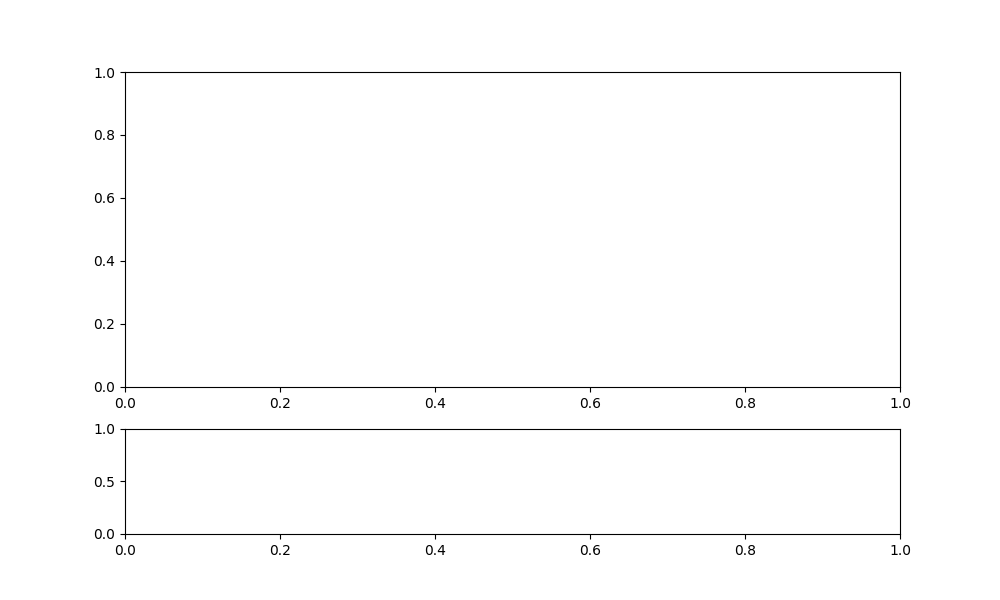

Starting optimization for first order model...
	 Initial cost function: 347.21
	 Final cost function: 332.86
alpha=611.79 	 tau1=0.254


Starting optimization for second order model...
	 Initial cost function: 310.41
	 Final cost function: 229.21
alpha=570.96 	 tau1=0.202 	 tau2=0.026


(TransferFunction(array([611.78579225]), array([0.2535543, 1.       ])),
 TransferFunction(array([570.96134771]), array([0.00532605, 0.22802562, 1.        ])))

In [3]:
motor.get_models_prbs(mi_motor, yop=360)

### Sintonía algebraica de PI para el motor

Antes de comenzar esta guia, revise cuidadosamente y comprenda el [material sobre sintonía algebraica de un  PI para un sistema de primer orden de este documento.](https://github.com/nebisman/UNThermal/blob/main/docs/metodo_sintonia_algebraico_PI_PID.pdf).

Una vez realizada esta revisión realice el siguiente trabajo experimental.


#### Experimento de sintonización de controladores

1. Use el método de sintonía algebraica descrito en el documento para obtener 4 controladores PI de la velocidad angular del motor,  de acuerdo con la siguiente tabla de especificaciones:

| Controlador | $t_{ee}$ (tiempo de establecimiento) | $t_r$ (tiempo de subida) | $SP$ (sobrepico) |
|-------------|-----------|-------|------|
| PI-VEL-1        | $1.5 s$     | $0.8 s$ | $10\%$  |
| PI-VEL-2        | $1.5 s$     | $0.8 s$ | $5\%$  |
| PI-VEL-3        | $1.5 s$     | $0.8 s$ | $0\%$  |
| PI-VEL-4        | $0.2 s$     | $0.1 s$ | $10\%$  |





#### Notas importantes:

1. El modelo usado para estos diseños es el modelo de primer orden obtenido con la función `get_models_prbs(.)` en el punto de operación de $360^o$.

2. Para el motor DC puede asumir que el tiempo de retraso no modelado es el tiempo de muestreo del controlador digital, esto es: 

$$T_{e}=0.02\,s$$

3. Se tiene también  la restricción de tensión que debemos (y podemos) aplicar al motor, dada por 
$$
|u(t)| \leq 5\,V
$$ 

4. Haga las iteraciones manualmente siguiendo el método, para ganar una comprensión intuitiva. Puede hacer los pasos 1-2 en una celda y en otra celda hacer los pasos 3-8, cambiando convenientemente los parámetros de diseño $\omega_n$ y $\zeta$. 

5. Use un cambio en la referencia de $0$ a $360^o/s$


6. Para todos los experimentos use la función `set_pid()` parametrizada con `beta=0` (para un PI de dos GDL) y con `output=speed` para el control de velocidad, como en el siguiente ejemplo. Puede usar la función `draw_specifications` dada a continuación para revisar los requerimientos de diseño. No tiene que definirla sino una vez.

Connected successfully to MQTT Broker!
succesfull change of PID parameters
Connected successfully to MQTT Broker!
Subscribed:  4   (2,)


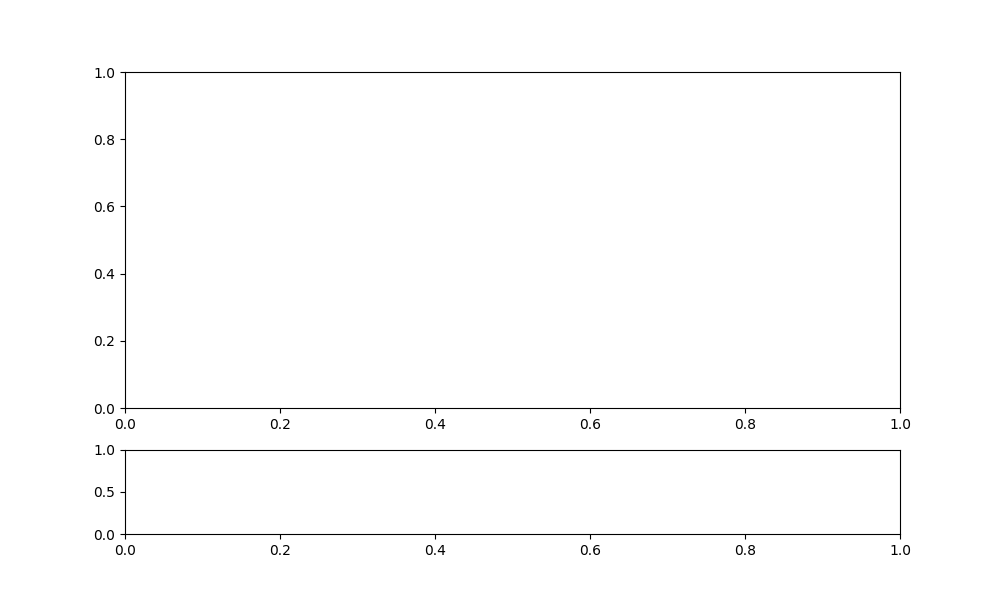

(<Axes: title={'center': 'Closed loop step response experiment with an initial value of  $r_0=$0.00 and a  final value of $r_0=$360.00'}, xlabel='Time(s)', ylabel='Degrees/s (or Degrees)'>,
 <Axes: xlabel='Time(s)', ylabel='Volts'>)

In [4]:
def draw_specifications(tee,tr, SP):
    import mplcursors
    fig=plt.gcf()
    ay, au = fig.get_axes()
    delta_r = r1 - r0

    # tee specification
    ay.axvline(tee+t0, color='#0080668F', linestyle='--', linewidth=1.25)
    ay.text(t0 +tee + t1/50 , r0 + 0.1*delta_r, "$t_{ee}=$", fontsize=14, color='#008066FF')

    # tr specification
    ay.plot([t0, t0+ tr, t0+ tr], [r0 + 0.9*delta_r, r0 + 0.9*delta_r, r0 - 0.1*delta_r],  color='#917c6fff', linestyle='--',linewidth=1.25)
    ay.text(t0 + tr + t1/50 , r0 + 0.1*delta_r, "$t_{r}$", fontsize=14,  color='#917c6fff')

    # SP specification
    ay.axhline(r1 + SP * delta_r /100, color='#d42affff', linestyle='--', linewidth=1.25)
    ay.text(0.8* t0 , r1 + (SP/100 + 0.025 ) * delta_r, "$SP$", fontsize=14, color='#d42affff')

    # pick in the graphic for returning values
    mplcursors.cursor(ay.lines) 
    return ay, au


# ejemplo de configuración del PI para el motor con control de  velocidad

# especificaciones 
tee = 0.8
tr =  0.25
SP = 10

# programacion del PI y respuesta al escalón 
t0 = 0.5
t1 = 2
r0 = 0
r1 = 360
motor.set_pid(mi_motor,kp=0.001, ki=0.02, kd=0, beta=0, output="speed")
t, r, y, u = motor.step_closed(mi_motor,r0=r0, r1=r1, t0=t0, t1=t1);
draw_specifications(tee, tr, SP)

#### Preguntas orientadoras

+ Al final de esta parte, además de los gráficos experimentales, presente una tabla con la siguiente información. 

| Controlador | $\zeta$ (final) | $\omega_n$ (final) |  $t_{ee}$ (real) | $t_r$ (real) | $SP$ (real) |

+ ¿Cual de estos controladores tiene la mejor respuesta a perturbaciones constantes, según la teoría y los resultados de la tabla?

### Experimento: Respuesta a perfiles de velocidad (rampas de aceleración programadas)


+ Obtenga el seguimiento a un perfil de velocidad usando la función  [`profile_closed()` (ver ayuda)](https://nebisman.github.io/UNThermal/profile_closed.html). para ***solo uno*** de los controladores PI diseñados para el motor controlado en velocidad.  . Use un perfil diseñado por usted y tenga en cuenta de generar rampas que el sistema alcance a seguir. 


+ Obtenga el seguimiento al perfil de velocidad con un controlador PI para el cual $\omega_n=0.8\omega_{max}$, siendo $\omega_{max}$ la frecuencia natural $\omega_n$ límite  a la cual sintonizó el el controlador. 


#### Preguntas orientadoras

+ Grafique la respuesta al perfil de velocidad de los dos controladores en una misma figura. El sintonizado con $\omega_{max}$ y el sintonizado con $\omega_n=0.8\omega_{max}$.


+ Compare el desempeño de los dos controladores ante el perfil de velocidad. 

Connected successfully to MQTT Broker!
Subscribed:  3   (2,)


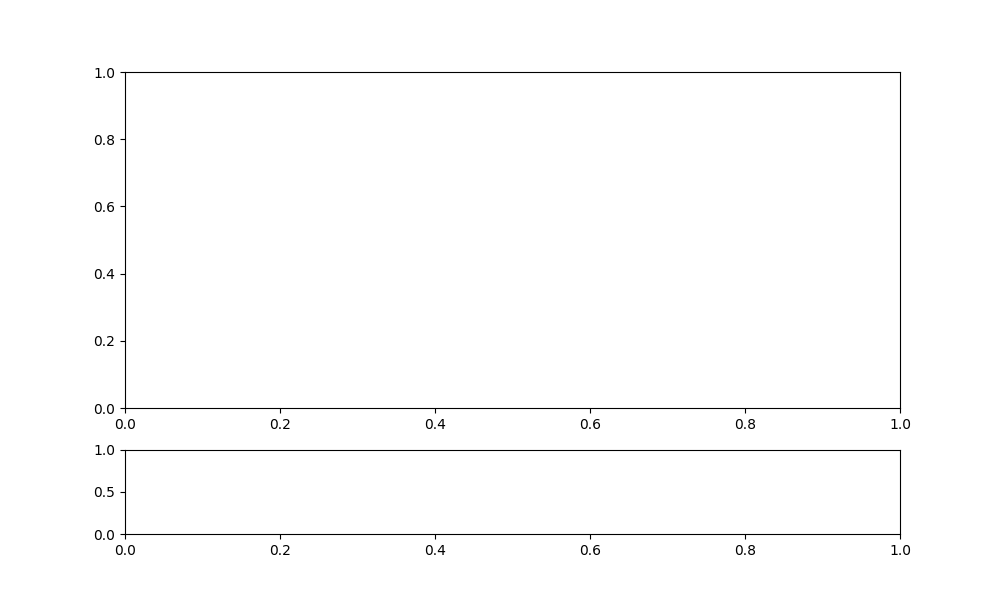

In [8]:
t_values = [0, 40, 80, 120, 160, 200]
r_values = [400, 700, 550, 550, 450, 700 ]
t, r, y, u = motor.profile_closed(mi_motor, timevalues=t_values , refvalues=r_values);

### Sintonía algebraica de PI para el sistema térmico

Los principios generales son los mismos que usó en el motor DC  y que están en la guia [material sobre sintonía algebraica de un  PI para un sistema de primer orden.](https://github.com/nebisman/UNThermal/blob/main/docs/metodo_sintonia_algebraico_PI_PID.pdf).

#### Experimentos

 Use el método de sintonía algebraica descrito en el documento para obtener 4 controladores PI del sistema térmico,  de acuerdo con la siguiente tabla de especificaciones:

| Controlador | $t_{ee}$ (tiempo de establecimiento) | $t_r$ (tiempo de subida) | $SP$ (sobrepico) |
|-------------|-----------|-------|------|
| PI-TEMP-1        | $40\, s$     | $20\, s$ | $10\%$  |
| PI-TEMP-2        | $40\, s$     | $20\, s$ | $5\%$  |
| PI-TEMP-3        | $3\, s$     | $1.5 s$ | $10\%$  |
| PI-TEMP-4        | $40\, s$     | $0.8 s$ | $0\%$  |





#### Notas importantes:

1. El modelo usado para estos diseños es el modelo de primer orden de la figura siguiente, el cual fue obtenido con la función `get_models_prbs(.)`

<img src="https://github.com/nebisman/UNThermal/blob/main/code/python_code/notebooks_lab_2024_2/prbs_response.png?raw=true" alt="Gráfica de resultados" width="1000"/>

2. Note que para el sistema térmico, se puede asumir que el tiempo de retraso no modelado, es el tiempo de muestreo del controlador digital, esto es: 

$$T_{e}=0.8\,s$$

3. Se tiene también  la restricción de señal de control que podemos aplicar al sistema térmico es el porcentaje de potencia: 
$$
|u(t)| \leq 100\% 
$$ 

4. Haga las iteraciones manualmente siguiendo el método, para ganar una comprensión intuitiva. Puede hacer los pasos 1-2 en una celda y en otra celda hacer los pasos 3-8, cambiando convenientemente los parámetros de diseño $\omega_n$ y $\zeta$. 


5. Use un cambio en la referencia de $60^o$ a $70^o$.  

6. Para todos los experimentos use la función `set_pid()` parametrizada con `beta=0` (para un PI de dos GDL), como en el siguiente ejemplo y puede usar la función `draw_specifications` para revisar los requerimientos de diseño. 


Successfully connected to MQTT Broker 192.168.1.100
Command send:  13
PID parameters changed
Successfully connected to MQTT Broker 192.168.1.100
Subscribed:  14   (2,)
Command send:  15


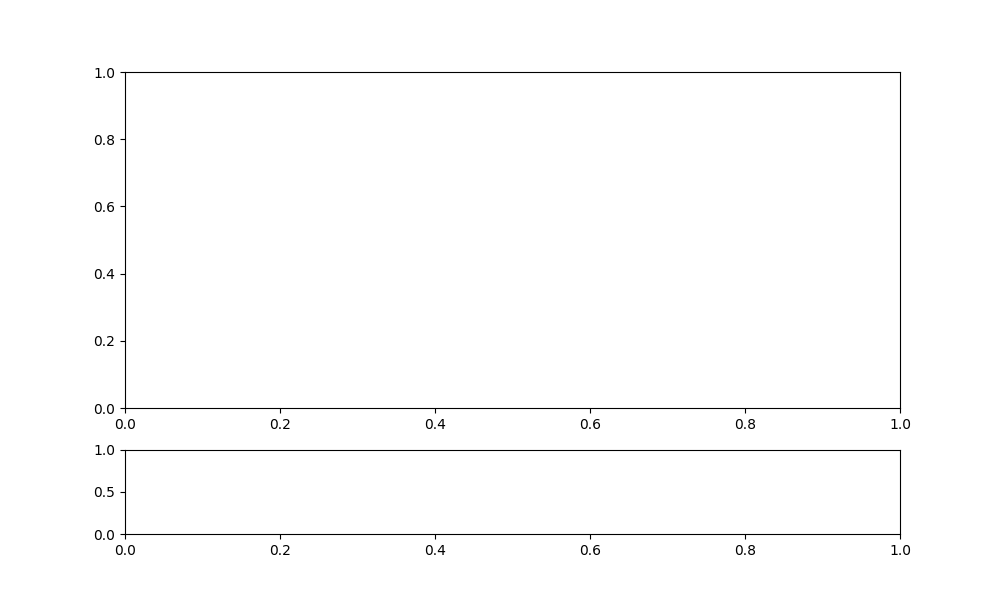

(<Axes: title={'center': 'Closed loop step response experiment with an initial value of  $r_0=$60.00 and a  final value of $r_0=$70.00'}, xlabel='Time (s)', ylabel='Power Input (%)'>,
 <Axes: xlabel='Time (s)'>)

In [11]:
# ejemplo de configuración del PI para sistema térmico

# especificaciones 
tee =40
tr = 0.8
SP = 0

# programacion del PI y respuesta al escalon

t0 = 70
t1 = 70
r0 = 60
r1 = 70
temp.set_pid(mi_termico, kp=4, ki=1, kd=0, beta=0)
t, r, y, u = temp.step_closed(mi_termico, r0=r0, r1=r1, t0=t0, t1=t1);

# funcion para dibujar los requerimientos de diseno
draw_specifications(tee, tr, SP)

#### Preguntas orientadoras

+ Al final de esta parte, además de los gráficos experimentales, presente una tabla con la siguiente información. 

| Controlador | $\zeta$ (final) | $\omega_n$ (final) |  $t_{ee}$ (real) | $t_r$ (real) | $SP$ (real) |

+ ¿Cual de estos controladores tiene la mejor respuesta a perturbaciones, según la teoría y los resultados de la tabla anterior ?

## Control PID del ángulo del motor DC

___

Revise cuidadosamente y comprenda el  [material sobre sintonía algebraica de un  PID para control de ángulo en un motor DC de este documento.](https://github.com/nebisman/UNThermal/blob/main/docs/metodo_sintonia_algebraico_PI_PID.pdf) Una vez realizada esta revisión, realice el siguiente trabajo experimental.


### Experimentos


1. Use la función `get_models_prbs(.)` para obtener un modelo en baja velocidad, en el punto de operación $y_{OP}=100^o/s$.

2.  Use el método de sintonía algebraica descrito en el [documento](https://github.com/nebisman/UNThermal/blob/main/docs/metodo_sintonia_algebraico_PI_PID.pdf) para obtener 4 controladores PID para el control del ángulo $\theta$ del motor,  de acuerdo con la siguiente tabla de especificaciones:

| Controlador | $t_{ee}$ (tiempo de establecimiento) | $t_r$ (tiempo de subida) | $SP$ (sobrepico) |
|-------------|-----------|-------|------|
| PID-ANGULO-1        | $0.2 s$     | $0.1 s$ | $10\%$  |
| PID-ANGULO-2        | $1.5 s$     | $0.8 s$ | $10\%$  |
| PID-ANGULO-3        | $1.5 s$     | $0.8 s$ | $5\%$  |
| PID-ANGULO-4        | $1.5 s$     | $0.8 s$ | $0\%$  |



#### Notas importantes:

1. El modelo usado para estos diseños es el modelo de primer orden ontenido con la función `get_models_prbs(.)` a una velocidad de $100^o/s$.

2. Note que para el motor DC puede asumir que el tiempo de retraso no modelado, es el tiempo de muestreo del controlador digital, esto es: 

$$T_{e}=0.02\,s$$

3. Se tiene también  la restricción de tensión que debemos (y podemos) aplicar al motor, dada por 
$$
|u(t)| \leq 5\,V
$$ 

4. Haga las iteraciones manualmente siguiendo el método, para ganar una comprensión intuitiva. Puede hacer los pasos 1-2 en una celda y en otra celda hacer los pasos 3-9, cambiando convenientemente los parámetros de diseño $\omega_n$ y $\zeta$. 

5. Use un cambio en la referencia de $0$ a $100^o$.


6. Para todos los experimentos use la función `set_pid()` parametrizada con `beta=0` (para un PI de dos GDL) y con `output=angle` para control de ángulo, como en el siguiente ejemplo. Puede usar la función `draw_specifications` para revisar los requerimientos de diseño. 

Connected successfully to MQTT Broker!
succesfull change of PID parameters
Connected successfully to MQTT Broker!
Subscribed:  26   (2,)


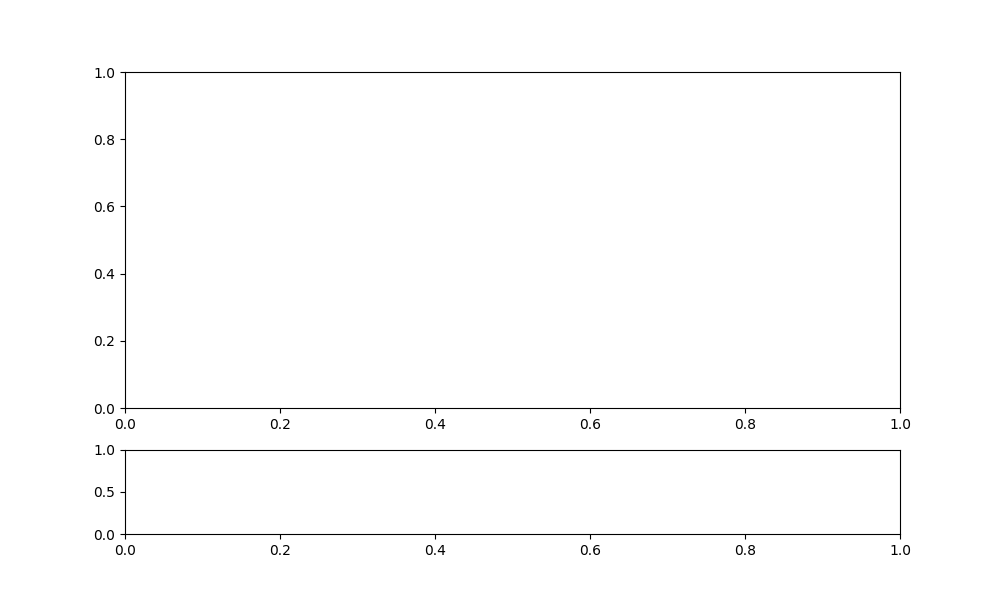

(<Axes: title={'center': 'Closed loop step response experiment with an initial value of  $r_0=$0.00 and a  final value of $r_0=$100.00'}, xlabel='Time(s)', ylabel='Degrees/s (or Degrees)'>,
 <Axes: xlabel='Time(s)', ylabel='Volts'>)

In [20]:
# ejemplo de configuración del PID para el motor con control de ángulo

# especificaciones 
tee = 1.5
tr =  0.8
SP = 0

# programacion del PID y respuesta al escalón 
t0 = 0.5
t1 = 2
r0 = 0
r1 = 100

motor.set_pid(mi_motor,kp=0.075, ki=1, kd=0.01, beta=0, output="angle", deadzone=0)
t, r, y, u = motor.step_closed(mi_motor,r0=r0, r1=r1, t0=t0, t1=t1);
draw_specifications(tee, tr, SP)

#### Preguntas orientadoras


+ Al final de esta parte, además de los gráficos experimentales, presente una tabla con la siguiente información. 

| Controlador | $\zeta$ (final) | $\omega_n$ (final) |  $t_{ee}$ (real) | $t_r$ (real) | $SP$ (real) | 

+ ¿Cuál de estos controladores tiene la mejor respuesta a perturbaciones, según la teoría y los resultados de la tabla ?

### Experimento con $\zeta<0$


+ Para el controlador PID-ANGULO-2 cambie el valor de $\zeta$ por $-\zeta$ y calcule las constantes del PID. Programe el PID y obtenga la respuesta al escalón.

#### Pregunta orientadora

Observe y explique el fenómeno del experimento anterior. 




#### Experimento respuesta a perfiles de ángulo (rampas de velocidad programadas)


+ Obtenga el seguimiento a un perfil de ángulo usando la función `profile_closed()` para ***solo uno*** de los controladores PID  diseñados para el control de ángulo del motor DC. Use un perfil diseñado por usted y tenga en cuenta de generar rampas que el motor pueda alcanzar. 


+ Obtenga el seguimiento a un perfil de ángulo con un controlador PID para el cual $\omega_n=0.8\omega_{max}$, siendo $\omega_{max}$ la frecuencia natural $\omega_n$ límite  a la cual sintonizó el controlador diseñado. 



#### Preguntas orientadoras

+ Grafique la respuesta al perfil de ángulo  de los dos controladores en la misma figura. El sintonizado con $\omega_{max}$ y el sintonizado con $\omega_n=0.8\omega_{max}$.

+ Compare el desempeño de los dos controladores.

## Reto para bonificación

Estos puntos son un reto para bonificación. Son completamente opcionales. 

+ Con base en el método de sintonía algebraica, programe una función de autosintonía que ajuste los parámetros PI para el control de velocidad del motor o para el sistema térmico, dado un determinado sobrepico, tiempo de establecimiento y tiempo de subida. 


+ Con base en el método de sintonía algebraica, programe una función de autosintonía que ajuste los parámetros PID para el control de ángulo del motor, dado un determinado sobrepico, tiempo de establecimiento y tiempo de subida.